# League of Legends Win Prediction using Robust PCA + Logistic Regression

This notebook presents a streamlined pipeline for classifying match outcomes in ranked solo/duo games of League of Legends using post-game performance data. We begin with exploratory data analysis (EDA) to understand win distributions, champion roles, and feature correlations. From there, we preprocess the data by isolating numeric variables and assessing the need for dimensionality reduction.

To enhance robustness, we implement Robust PCA manually and extract the data's low-rank structure. This denoised data is further reduced using standard PCA, and the resulting principal components are used to train a logistic regression model. Validation is performed via both a shuffle test and k-fold cross-validation to ensure reliable performance estimates.


# Importing Libraries

This section loads the core Python libraries required for data manipulation, visualization, and linear algebra operations used throughout the analysis.

In [3]:
#core libraries
import numpy as np
import pandas as pd
import numpy.linalg as LA

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#statistics
from scipy.stats import skew

#data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

#dimensionality reduction
from sklearn.decomposition import PCA

#model training and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Load and Prepare Dataset

The dataset is loaded from a local CSV file. The `win` column is read as a string initially to ensure precise control over its conversion later into a binary classification variable.

In [5]:
#load the CSV file, treating 'win' as string for proper conversion later
df_csv = pd.read_csv("league_data.csv", dtype={'win': str})

#full list of columns to drop (metadata, redundant, or constant after filtering)
columns_to_drop = [
    'game_id', 'game_version', 'participant_id', 'puuid', 'summoner_name', 'summoner_id',
    'solo_tier', 'solo_rank', 'solo_lp', 'solo_wins', 'solo_losses',
    'flex_tier', 'flex_rank', 'flex_lp', 'flex_wins', 'flex_losses',
    'champion_mastery_lastPlayTime', 'champion_mastery_lastPlayTime_utc',
    'champion_id', 'map_id', 'platform_id', 'game_type', 'team_id',
    'game_start_utc', 'queue_id', 'game_mode'  
]

#filter for CLASSIC Ranked Solo/Duo only
df_filtered = df_csv[(df_csv['game_mode'] == 'CLASSIC') & (df_csv['queue_id'] == 420)].copy()

#drop listed columns (if they exist)
columns_to_drop_existing = [col for col in columns_to_drop if col in df_filtered.columns]
df_filtered_cleaned = df_filtered.drop(columns=columns_to_drop_existing)

#convert 'win' to binary: 1 = Win, 0 = Loss
df_filtered_cleaned['win'] = (df_filtered['win'] == 'TRUE').astype(int)

#confirm shape and column names
df_filtered_cleaned.shape, df_filtered_cleaned.columns.tolist()

((21910, 68),
 ['game_duration',
  'summoner_level',
  'champion_name',
  'win',
  'individual_position',
  'team_position',
  'lane',
  'role',
  'kills',
  'deaths',
  'assists',
  'baron_kills',
  'dragon_kills',
  'gold_earned',
  'gold_spent',
  'total_damage_dealt',
  'total_damage_dealt_to_champions',
  'physical_damage_dealt_to_champions',
  'magic_damage_dealt_to_champions',
  'true_damage_dealt_to_champions',
  'damage_dealt_to_objectives',
  'damage_dealt_to_turrets',
  'total_damage_taken',
  'physical_damage_taken',
  'magic_damage_taken',
  'true_damage_taken',
  'time_ccing_others',
  'vision_score',
  'wards_placed',
  'wards_killed',
  'vision_wards_bought_in_game',
  'item0',
  'item1',
  'item2',
  'item3',
  'item4',
  'item5',
  'item6',
  'champion_mastery_level',
  'champion_mastery_points',
  'champion_mastery_pointsSinceLastLevel',
  'champion_mastery_pointsUntilNextLevel',
  'champion_mastery_tokensEarned',
  'final_abilityHaste',
  'final_abilityPower',
  'fi

## Win Rate Distribution

The `win` column is mapped from string labels to binary values: `1` for a win and `0` for a loss. This conversion sets the foundation for supervised classification tasks. A count plot is used to visualize the class distribution, helping us check whether the dataset is balanced. Class balance is important because heavily imbalanced datasets can bias predictive models and lead to misleading performance metrics.

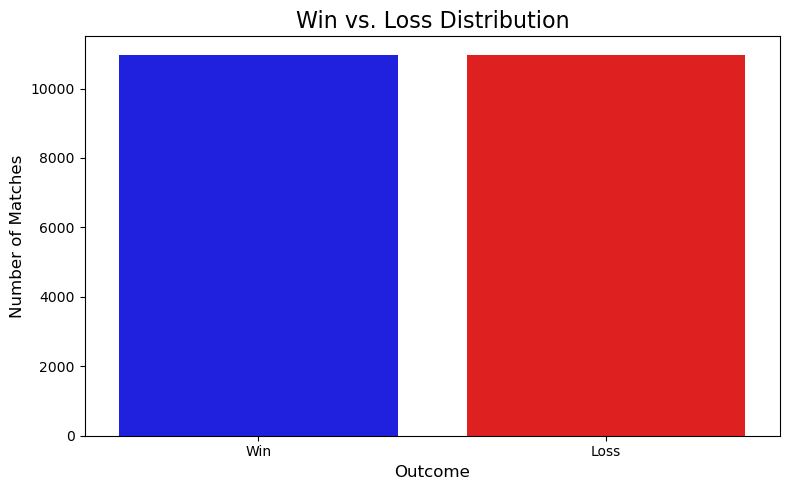

In [7]:
#explicitly map win values to categorical labels so they are centered nicely
df_filtered_cleaned['win_label'] = df_filtered_cleaned['win'].map({0: 'Loss', 1: 'Win'})

plt.figure(figsize=(8, 5))
sns.countplot(data=df_filtered_cleaned, x='win_label', hue='win_label', palette={'Loss': 'red', 'Win': 'blue'}, legend=False)

plt.title("Win vs. Loss Distribution", fontsize=16)
plt.xlabel("Outcome", fontsize=12)
plt.ylabel("Number of Matches", fontsize=12)
plt.tight_layout()
plt.show()



## Champion & Role Frequencies

We examine the frequency of champions and roles played in the dataset. These counts offer insight into the most popular gameplay strategies and help us understand trends in the meta. Frequent appearances may also introduce bias, which should be accounted for in any downstream analysis or modeling.

In [9]:
#Frequency Counts for champions and roles
champion_counts = df_filtered_cleaned['champion_name'].value_counts().reset_index()
champion_counts.columns = ['champion_name', 'count']
print("Champion Frequency Count:")
print(champion_counts.to_string(index=False))

print("\n" + "="*50 + "\n")

# Role frequency count
role_counts = df_filtered_cleaned['role'].value_counts().reset_index()
role_counts.columns = ['role', 'count']
print("Role Frequency Count:")
print(role_counts.to_string(index=False))

Champion Frequency Count:
champion_name  count
  MissFortune    423
      Caitlyn    421
         Jinx    411
         Lulu    405
        Viego    362
         Jhin    358
          Lux    345
   MonkeyKing    324
       Viktor    312
       Ezreal    299
     Vladimir    286
         Nami    276
     Katarina    252
        Yasuo    238
        Diana    233
        Janna    233
        Karma    232
       Thresh    227
    TahmKench    221
        Corki    218
       Syndra    217
       Twitch    217
       Darius    214
         Yone    212
     JarvanIV    208
        Sylas    205
        Vayne    196
  Mordekaiser    195
         Kayn    193
     Nocturne    192
     Volibear    190
        Kaisa    182
      Chogath    181
       Draven    179
         Ashe    178
       Irelia    177
        Kayle    170
        Amumu    169
      Hecarim    167
       LeeSin    167
        Garen    166
     Malzahar    163
        Milio    163
      Warwick    161
         Ahri    159
     Nau

## Correlation Analysis

This heatmap displays the pairwise correlation between all quantitative variables. Identifying strong correlations helps us detect potential redundancy and multicollinearity, which can distort model interpretation or inflate variance. These patterns will inform dimensionality reduction choices, such as PCA, later in the workflow.

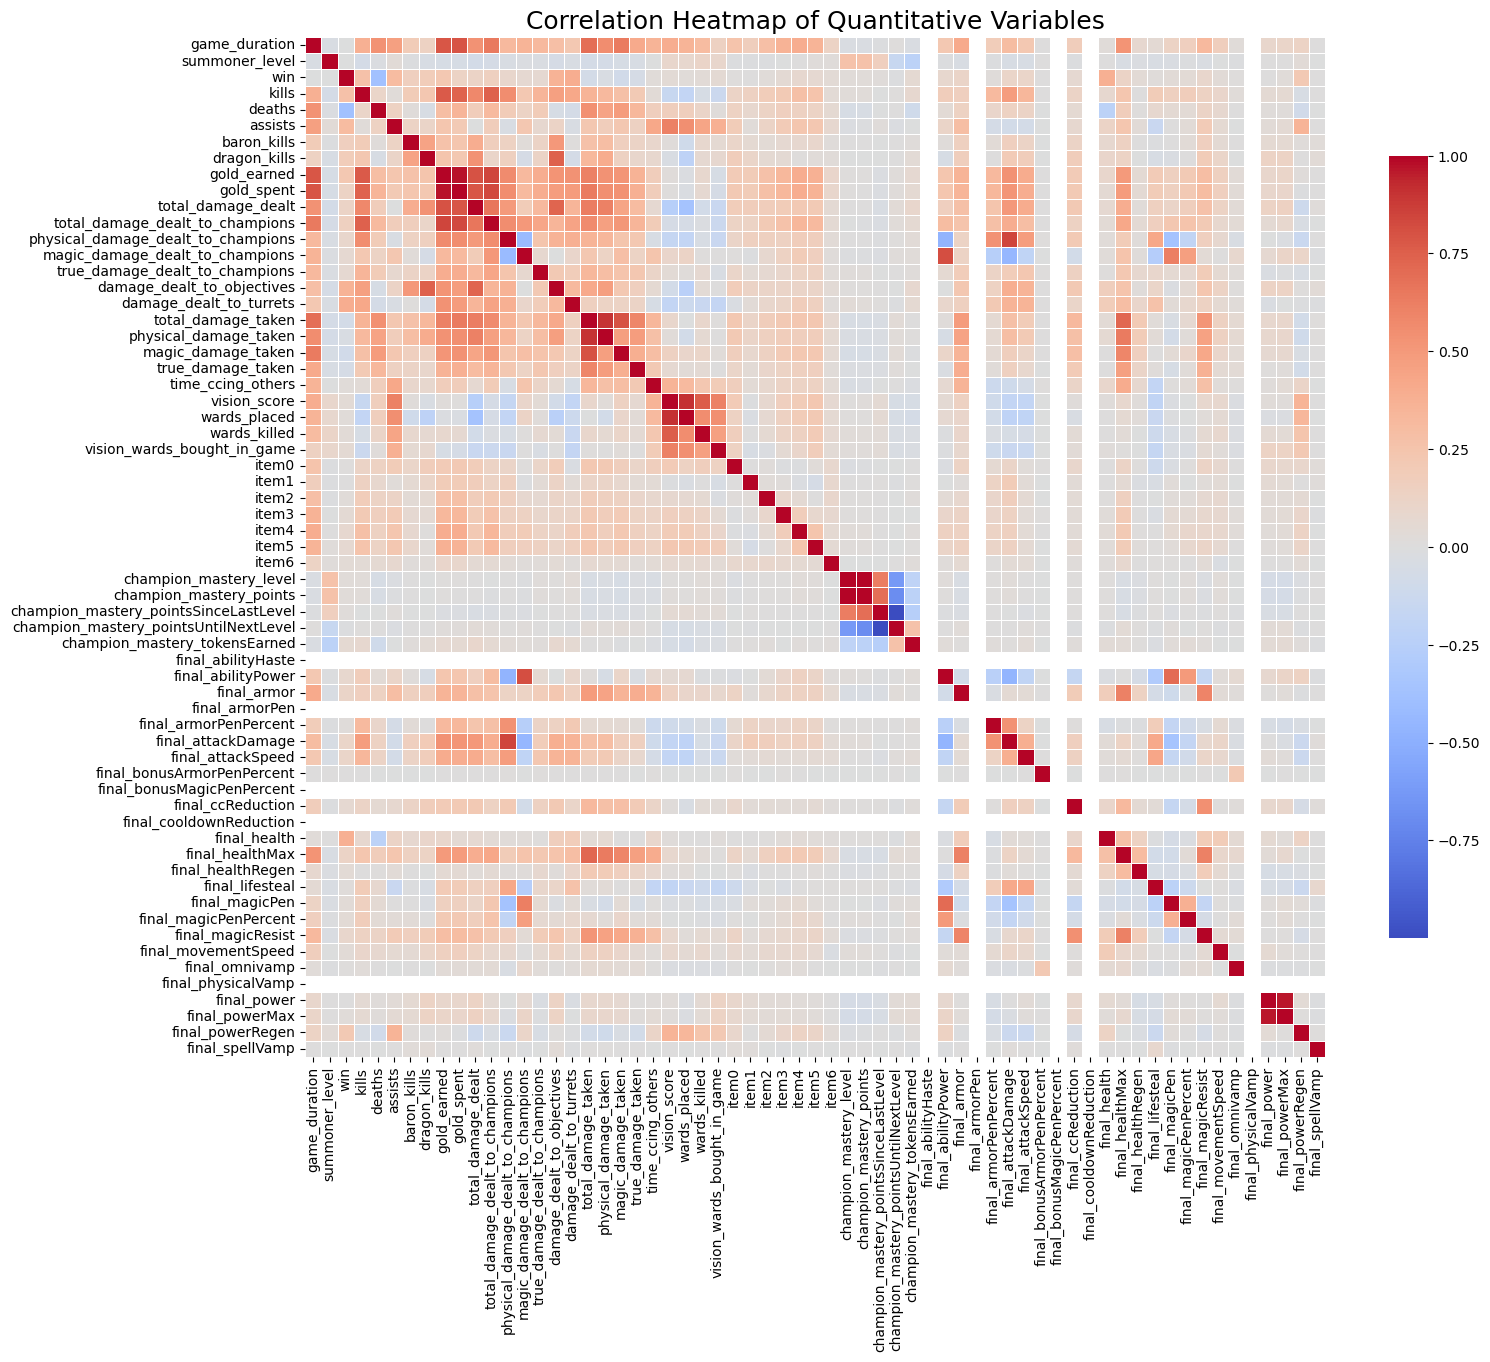

In [11]:
#Correlation Heatmap
#select quantitative (numeric) columns
quantitative_columns = df_filtered_cleaned.select_dtypes(include=['number']).columns

#compute the correlation matrix
correlation_matrix = df_filtered_cleaned[quantitative_columns].corr()

#plot the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.7})

plt.title("Correlation Heatmap of Quantitative Variables", fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### High Correlation Pairs

To pinpoint potential sources of multicollinearity, we extract all variable pairs with correlation above a threshold of 0.75. These pairs suggest redundancy, where multiple features may be capturing the same underlying information. Identifying these relationships supports informed decisions on feature selection or motivates the use of dimensionality reduction techniques like PCA.

In [13]:
#list correlated quantitative variables with correlation coefficient above 0.75
#set the threshold
threshold = 0.75

#get numeric columns
quantitative_columns = df_filtered_cleaned.select_dtypes(include=['number']).columns
correlation_matrix = df_filtered_cleaned[quantitative_columns].corr()

#find pairs with high absolute correlation
high_corr_pairs = [
    (col1, col2, correlation_matrix.loc[col1, col2])
    for i, col1 in enumerate(quantitative_columns)
    for j, col2 in enumerate(quantitative_columns)
    if i < j and abs(correlation_matrix.loc[col1, col2]) > threshold
]

#sort and print
high_corr_pairs_sorted = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)

print("Highly Correlated Variable Pairs (|r| > 0.75):\n")
for var1, var2, corr in high_corr_pairs_sorted:
    print(f"{var1} ↔ {var2} | r = {corr:.3f}")


Highly Correlated Variable Pairs (|r| > 0.75):

champion_mastery_pointsSinceLastLevel ↔ champion_mastery_pointsUntilNextLevel | r = -1.000
champion_mastery_level ↔ champion_mastery_points | r = 0.996
gold_earned ↔ gold_spent | r = 0.975
final_power ↔ final_powerMax | r = 0.965
vision_score ↔ wards_placed | r = 0.914
total_damage_taken ↔ physical_damage_taken | r = 0.902
gold_earned ↔ total_damage_dealt_to_champions | r = 0.847
physical_damage_dealt_to_champions ↔ final_attackDamage | r = 0.846
gold_spent ↔ total_damage_dealt_to_champions | r = 0.835
magic_damage_dealt_to_champions ↔ final_abilityPower | r = 0.817
gold_earned ↔ total_damage_dealt | r = 0.800
total_damage_taken ↔ magic_damage_taken | r = 0.799
game_duration ↔ gold_spent | r = 0.789
gold_spent ↔ total_damage_dealt | r = 0.786
game_duration ↔ gold_earned | r = 0.784
kills ↔ gold_earned | r = 0.773
vision_score ↔ wards_killed | r = 0.764


# Check for Robust PCA Necessity

Before applying standard PCA, we assess whether a robust version is more appropriate. Robust PCA is designed to handle datasets with outliers or heavy-tailed distributions, which can distort the principal components in classical PCA. This step ensures that the decomposition reflects genuine structure rather than noise or anomalies.

## Identify Numeric Variables

We identify columns that are truly numeric and exclude those that, while stored as numbers, function as categorical identifiers (e.g., item IDs). This distinction is essential because such pseudo-numeric variables can distort PCA and other analyses by introducing artificial structure not grounded in meaningful magnitude or variance.

In [16]:
quantitative_columns = df_filtered_cleaned.select_dtypes(include=['number']).columns
quantitative_data = df_filtered_cleaned[quantitative_columns]

#outlier detection using IQR method
outlier_info = []

for col in quantitative_data.columns:
    q1 = quantitative_data[col].quantile(0.25)
    q3 = quantitative_data[col].quantile(0.75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    outlier_count = ((quantitative_data[col] < lower_fence) | (quantitative_data[col] > upper_fence)).sum()
    outlier_info.append((col, outlier_count))

#format and display
outlier_df = pd.DataFrame(outlier_info, columns=['Variable', 'Outlier Count'])
outlier_df = outlier_df.sort_values(by='Outlier Count', ascending=False)

print("Outlier Count per Quantitative Variable:\n")
print(outlier_df.to_string(index=False))


Outlier Count per Quantitative Variable:

                             Variable  Outlier Count
                                item2           9119
                                item3           8673
                       final_magicPen           4808
                         dragon_kills           4778
                    final_ccReduction           4298
                     final_powerRegen           3458
                      final_lifesteal           3208
                    final_healthRegen           2906
                final_armorPenPercent           2849
              champion_mastery_points           2611
               champion_mastery_level           2585
                  final_movementSpeed           2400
                         vision_score           2378
                final_magicPenPercent           2123
champion_mastery_pointsUntilNextLevel           2070
champion_mastery_pointsSinceLastLevel           2007
                         wards_placed           2004
    

## Remove Categorical Variables

We finalize the preprocessing by removing all non-numeric (categorical or object-type) columns. This ensures the resulting dataset is strictly quantitative, a prerequisite for applying PCA, logistic regression, and other algorithms that operate on continuous numerical inputs.

In [18]:
#remove all categorical variables from the data (object or category type)
df_numeric_only = df_filtered_cleaned.drop(columns=df_filtered_cleaned.select_dtypes(include=['object', 'category']).columns)

#drop item columns explicitly (even though are may be numeric, they are IDs)
item_columns = [col for col in df_numeric_only.columns if col.startswith("item")]
df_numeric_only = df_numeric_only.drop(columns=item_columns)

#recalculate outliers and skewness, high skewness is |skewness|>1
outlier_info = []
skewness_info = []

for col in df_numeric_only.columns:
    if col == 'win':
        continue
    q1 = df_numeric_only[col].quantile(0.25)
    q3 = df_numeric_only[col].quantile(0.75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    outlier_count = ((df_numeric_only[col] < lower_fence) | (df_numeric_only[col] > upper_fence)).sum()
    outlier_info.append((col, outlier_count))
    skew_val = skew(df_numeric_only[col].dropna())
    skewness_info.append((col, skew_val))

#format and display
outlier_df = pd.DataFrame(outlier_info, columns=['Variable', 'Outlier Count'])
skewness_df = pd.DataFrame(skewness_info, columns=['Variable', 'Skewness'])
eda_summary = pd.merge(outlier_df, skewness_df, on='Variable').sort_values(by='Outlier Count', ascending=False)

print("EDA Summary: Outlier Count and Skewness\n")
print(eda_summary.to_string(index=False))

EDA Summary: Outlier Count and Skewness

                             Variable  Outlier Count   Skewness
                       final_magicPen           4808   2.223273
                         dragon_kills           4778   2.484334
                    final_ccReduction           4298   1.845652
                     final_powerRegen           3458   2.292677
                      final_lifesteal           3208   3.010088
                    final_healthRegen           2906  20.659101
                final_armorPenPercent           2849   2.455695
              champion_mastery_points           2611   5.673979
               champion_mastery_level           2585   5.788931
                  final_movementSpeed           2400   2.164433
                         vision_score           2378   1.990228
                final_magicPenPercent           2123   5.023595
champion_mastery_pointsUntilNextLevel           2070  -5.279387
champion_mastery_pointsSinceLastLevel           2007   5.221366

# Robust PCA Implementation

This section implements Robust PCA manually to maintain control over the decomposition process. Available Python libraries either fail to handle missing values gracefully or lack flexibility. By crafting a custom solution, we ensure that the decomposition separates low-rank structure from sparse noise, capturing essential variance while minimizing the influence of outliers.

In [20]:
# === STEP 1: Prepare the data ===
#drop the response column
X = df_numeric_only.drop(columns=['win'])
y = df_numeric_only['win']

#fill missing values with column means 
X_filled = X.fillna(X.mean())

#standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)

# === STEP 2: Manual Robust PCA (PCP Method) ===
#PCP is principal component pursuit
#L is low-rank approximation - "clean" signal, S is sparse matrix - outliers or anomalies

def robust_pca(M, max_iter=1000, tol=1e-7):
    def shrinkage_operator(x, tau):
        return np.sign(x) * np.maximum(np.abs(x) - tau, 0.)

    def svd_thresholding_operator(X, tau):
        U, S, Vh = LA.svd(X, full_matrices=False)
        S_thresh = shrinkage_operator(S, tau)
        return U @ np.diag(S_thresh) @ Vh

    S = np.zeros_like(M)
    Y = np.zeros_like(M)
    mu = np.prod(M.shape) / (4.0 * LA.norm(M, ord=1))
    mu_inv = 1.0 / mu
    lam = 1.0 / np.sqrt(np.max(M.shape))

    for _ in range(max_iter):
        L = svd_thresholding_operator(M - S + mu_inv * Y, mu_inv)
        S = shrinkage_operator(M - L + mu_inv * Y, lam * mu_inv)
        Y = Y + mu * (M - L - S)
        error = LA.norm(M - L - S, ord='fro')
        if error < tol:
            break

    return L, S

#run Robust PCA
L, S = robust_pca(X_scaled)

# === STEP 3: Inspect results ===
print("Manual Robust PCA Complete")
print(f"Low-rank matrix shape: {L.shape}")
print(f"Sparse outlier matrix shape: {S.shape}")
print(f"Frobenius norm of S (outlier strength): {np.linalg.norm(S, 'fro'):.2f}")



Manual Robust PCA Complete
Low-rank matrix shape: (21910, 55)
Sparse outlier matrix shape: (21910, 55)
Frobenius norm of S (outlier strength): 229.27


## Logistic Regression on RPCA Output

After extracting the low-rank structure (L matrix) from Robust PCA, we apply standard PCA to it, transforming the denoised data into principal components. These components then serve as input features for a logistic regression model, allowing us to predict match outcomes based on the compressed and cleaned representation of the original data.

Number of components to reach 80% variance: 14


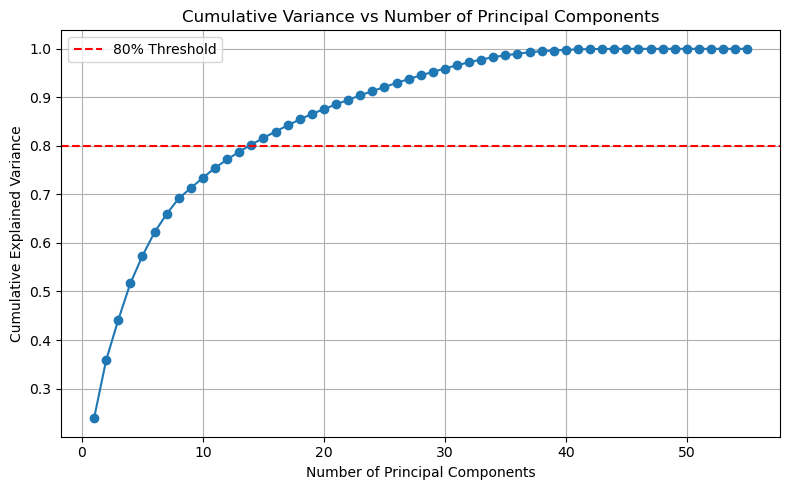

Robust PCA + Logistic Regression Results
Accuracy:  0.8199
F1 Score:  0.8191
ROC AUC:   0.8997


In [22]:
#takes L matrix from robust PCA and puts it into logistic regression function
# === Step 1: Apply PCA to the low-rank matrix (L from robust_pca)
pca_robust = PCA()
L_pca = pca_robust.fit_transform(L)

# === Step 2: Determine number of PCs to capture ≥80% variance
cumulative_variance = np.cumsum(pca_robust.explained_variance_ratio_)
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Number of components to reach 80% variance: {n_components_80}")

#also show plot of number of principal components vs cumulative variance with 80% threshold line
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance vs Number of Principal Components')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Step 3: Use those components for logistic regression
X_pca_80 = L_pca[:, :n_components_80]

X_train, X_test, y_train, y_test = train_test_split(X_pca_80, y, test_size=0.3, stratify=y)

log_reg = LogisticRegression(penalty=None, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# === Step 4: Evaluate performance
print("Robust PCA + Logistic Regression Results")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")


## Model Validation (Shuffle + CV)

We validate the robustness of our PCLR model using two complementary strategies: shuffle test/label permutation and k-fold cross-validation. The shuffle test helps detect overfitting by testing the model on data with randomized labels, while k-fold CV estimates generalization performance across multiple training/test splits. Together, these methods ensure our results are not an artifact of random chance.

In [24]:
# Shuffle Test/Label Permutation
# =========================
_, y_shuffled = shuffle(X_pca_80, y)

X_train, X_test, y_train_shuff, y_test_shuff = train_test_split(
    X_pca_80, y_shuffled, test_size=0.3, stratify=y_shuffled
)

logreg_rpclr_shuff = LogisticRegression(penalty=None, max_iter=1000)
logreg_rpclr_shuff.fit(X_train, y_train_shuff)
y_proba_shuff = logreg_rpclr_shuff.predict_proba(X_test)[:, 1]

print("RPCLR (80% variance PCs) – Shuffle Test")
print(f"ROC AUC (Shuffled): {roc_auc_score(y_test_shuff, y_proba_shuff):.4f}\n")

# =========================
# 5-Fold Cross-Validation
# =========================
kf = StratifiedKFold(n_splits=5, shuffle=True)
auc_scores = []

for train_index, test_index in kf.split(X_pca_80, y):
    X_train, X_test = X_pca_80[train_index], X_pca_80[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression(penalty=None, max_iter=1000)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)

print("RPCLR (80% variance PCs) – 5-Fold Cross-Validation")
print("AUCs:", np.round(auc_scores, 4))
print(f"Mean AUC: {np.mean(auc_scores):.4f} | Std Dev: {np.std(auc_scores):.4f}")

RPCLR (80% variance PCs) Shuffle Test
ROC AUC (Shuffled): 0.4958

RPCLR (80% variance PCs) 5-Fold Cross-Validation
AUCs: [0.9047 0.9142 0.9021 0.9022 0.9147]
Mean AUC: 0.9076 | Std Dev: 0.0057
